# Downloading the files required for the project

- The files required for this project are uploaded on google drive and the following code just downloads the files present in the shared folder
- The following files are downloaded
- **Train.csv**, **Test.csv**, **Mapping.csv**
- pre-trained **glove.6B.50d.txt** word embedding
- model-related files trained by this project

In [ ]:
from google.colab import auth
from googleapiclient.discovery import build
import io
from googleapiclient.http import MediaIoBaseDownload

# Authenticate and create the Drive API client
auth.authenticate_user()
drive_service = build('drive', 'v3')

# Replace 'YOUR_FOLDER_ID' with the actual folder ID from the shared link
folder_id = '1oM7jop65iIfYuKeamvU65Dwt1WkhMkCs'

# Set the destination path where you want to download the folder
destination_path = '/content/twitter_dataset'

# Create the destination directory if it doesn't exist
!mkdir -p "{destination_path}"

# Function to list all files in a folder
def list_files(service, folder_id):
    results = service.files().list(q=f"'{folder_id}' in parents", fields="files(id, name)").execute()
    files = results.get('files', [])
    return files

# Function to download files recursively from Google Drive
def download_files(service, file_id, destination_path, file_name):
    request = service.files().get_media(fileId=file_id)
    fh = io.FileIO(f"{destination_path}/{file_name}", 'wb')
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        print(f"Download {int(status.progress() * 100)}%")

# Download the entire folder recursively
def download_folder(service, folder_id, destination_path):
    files = list_files(service, folder_id)

    for file in files:
        file_id = file['id']
        file_name = file['name']
        file_destination_path = f"{destination_path}/{file_name}"

        if service.files().get(fileId=file_id).execute().get('mimeType') == 'application/vnd.google-apps.folder':
            # If it's a folder, create the folder and download its contents
            !mkdir -p "{file_destination_path}"
            download_folder(service, file_id, file_destination_path)
        else:
            # If it's a file, download the file
            download_files(service, file_id, destination_path, file_name)

# Start downloading the folder
download_folder(drive_service, folder_id, destination_path)

print(f'The folder has been downloaded to {destination_path}')


Download 100%
Download 100%
Download 100%
Download 100%
Download 100%
Download 100%
Download 100%
Download 100%
Download 100%
Download 100%
Download 100%
Download 100%
Download 100%
Download 61%
Download 100%
The folder has been downloaded to /content/twitter_dataset


In [ ]:
%pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.9/457.9 kB 9.5 MB/s eta 0:00:00


In [ ]:
# required libraries
import numpy as np
# pandas is a library using which we can work with ordered data - csv files in our case
import pandas as pd
# library for saving the trained models and the parameters of the pipeline
import pickle
import matplotlib.pyplot as plt
import emoji

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical #one-hot encoding
from imblearn.over_sampling import SMOTE #library to handle unbalanced datasets

# Loading Dataset

## Explaining the data

- Each emoji is given a label and this label is specified in **Mapping.csv**
- **Train.csv** contains two significant columns, one of which contains **tweets** from **Twitter** and the second columns consists of the label for the corresponding emoji
- **Test.csv** just contains the tweets for testing the model

In [ ]:
train_file = '/content/twitter_dataset/Train.csv' #file path for the training dataset
data = pd.read_csv(train_file)
data.rename(columns={data.columns[0]:"number","TEXT":"text","Label":"label"},inplace=True) #renaming/adding column names
data.drop(['number'],axis=1,inplace=True)
data.info() # a brief summary of the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    70000 non-null  object
 1   label   70000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [ ]:
data.sample(10) #sampling 10 datapoints at random

,text,label
41976,The club closes but we ain't ready to Stop #Da...,11
43442,Airport flow like ........ #tourlife #bonethug...,19
15597,Skyline neoyorkino nocturno #acabodellegaryyaq...,2
43220,"Laughs. The good, healthy ones #love #TFLers #...",10
12020,Beltline with my best bghegan @ Atlanta Beltli...,8
35441,@user found the prettiest neighborhood to take...,1
15001,#lit to the max @ North Philadelphia\n,0
61296,"JDM is so beautiful, wow @ Walker Stalker Con ...",2
27538,n_ntk see you next quarter #zombie_face @ Cal ...,3
52301,Tennis #usopen2017 #pinkshirt #whereiseverybod...,3


In [ ]:
mapping_file = '/content/twitter_dataset/Mapping.csv' #file path for mapping from emoji-label to actual emoji
emoji_mapping = pd.read_csv(mapping_file)
emoji_mapping.rename(columns={emoji_mapping.columns[0]:"number","emoticons":"emoji","number":"label"},inplace=True)
emoji_mapping.drop(['number'],axis=1,inplace=True)
emoji_mapping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   emoji   20 non-null     object
 1   label   20 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 448.0+ bytes


In [ ]:
emoji_mapping #listing the different emojis and their labels

,emoji,label
0,😜,0
1,📸,1
2,😍,2
3,😂,3
4,😉,4
5,🎄,5
6,📷,6
7,🔥,7
8,😘,8
9,❤,9


# Input Pre-Processing

- Steps taken for input-preprocessing
- We need to remove '#'(hashtags) '@'(mentions) from the dataset and also convert all the words to lowercase for better performance when using pre-trained word-embedding values
- We need to convert the string-stream to a number-stream for the model to work with. This technique is known as **Tokenization**. Each token is a number which acts as an index for that word in the word-embedding matrix
- Next we convert the token-stream into corresponding word-embedding vector form
- We need to convert each output label to a one-hot encoding scheme

In [ ]:
X = data["text"].values #extracting the tweets
Y = data["label"].values #extracting the corresponding emoji-labels

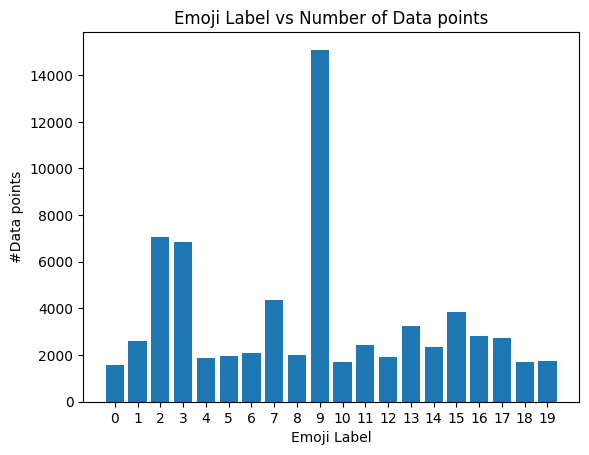

In [ ]:
vals, counts = np.unique(Y, return_counts=True) #
plt.bar(vals,counts)
plt.xticks(vals)
plt.xlabel('Emoji Label')
plt.ylabel('#Data points')
plt.title('Emoji Label vs Number of Data points')
plt.show()

# One Hot Encoding

- One-Hot Encoding is a technique to represent the label to be predicted in case of a multi-class classfication
- Basically we create a n-d binary output vector where n is the number of possible classes (20 in our case)
- In this encoding scheme, if a data-point x corresponds to yth class, then the value corresponding to the yth dimension is set to 1 whereas values for other dimensions are set to 0
- For example if there are a total of 5 classes and an input x belongs to 4th class then the output vector is (0,0,0,1,0)
- But why do we do this?
- We cannot simply label one emoji as 1 and the second as 2, because this implies that the second emoji is in some sense greater than first emoji. In other words labelling as 1 and 2 gives some ordinal relation to the labels and implies an inherent ordering. Hence we use one-hot encoding which does not give any ordering-preference to any label.

In [ ]:
Ytrain = to_categorical(Y) #converts all the training output vectors to one-hot encoding

In [ ]:
#removing hashtags, mentions, links
def clean(X):
    X = X.replace("#","") #remove '#' from words
    X = X.replace("@","") #remove '@' from mentions
    X = X.replace("http://","") #remove links
    X = X.replace("https://","") #remove links
    X = X.lower() #changing everything to lowercase
    return X

In [ ]:
#clean the data - basically remove all '#', '@' and links from the text
X = np.array([clean(x) for x in X])

# Tokenization

- Here we use a simple tokenizer which splits a text into space seperated words and then assigns numbers to the tokens
- We need to fit this tokenizer on the training dataset and can also save this fitted tokeinzer using the pickle library

In [ ]:
tokenizer = Tokenizer(oov_token='OOV')
tokenizer.fit_on_texts(X) #fitting the tokenizer on the training data
wrd_index = tokenizer.word_index #dictionary with key as the word and the value as the index (word:index)
print("The tokenizer has been fitted on", len(wrd_index),"words")
print("Printing some word:token pairs")
print(list(wrd_index.items())[:5])

The tokenizer has been fitted on 85877 words
Printing some word:token pairs
[('OOV', 1), ('the', 2), ('user', 3), ('my', 4), ('to', 5)]


Now we need to convert the training data which is currently a stream of strings into a stream of tokens where tokens are just numbers which correspond to that particular word in **wrd_index** dictionary

In [ ]:
X_tokens = tokenizer.texts_to_sequences(X) #convert the strings to tokens
X_tokens[:2],X[:2]

([[652, 6413, 15974, 5425, 1768, 24448, 24449, 152, 1413, 311],
  [214, 1372, 1188, 23, 634, 3, 1372, 203, 24450, 1373, 508, 10179]],
 array(['vacation wasted ! vacation2017 photobomb tired vacationwasted mcgar30 miami  port of…\n',
        'oh wynwood, you’re so funny! : user wynwood art itwas3am flowers vibes  wynwood…\n'],
       dtype='<U167'))

- Inorder to reduce the model complexity of the model we take a fixed sized input.
Inorder to do this we restrict the size of the input string to 20.
If the input token stream has more than 20 tokens then it is trimmed to the first 20 tokens and if the token stream has less than 20 tokens then it is suffixed with special token(s)/(0 token(s))
- Fixing the size of the input string also helps training a model faster as it enables **Batch Processing** where we can conveniently represent data as a fixed-sized matrix and efficiently use the hardware resources to parallely do the required computations.

In [ ]:
#padding the input string
max_len = 20
Xtrain = pad_sequences(X_tokens,maxlen=max_len,padding='post')
Xtrain[1]

array([  214,  1372,  1188,    23,   634,     3,  1372,   203, 24450,
        1373,   508, 10179,     0,     0,     0,     0,     0,     0,
           0,     0], dtype=int32)

In [ ]:
# saving the tokenizer for further use
# we can save the trained tokenizer using this block of code - note that for this path of the file you will first have to mount your google drive on this colab session
# from google.colab import drive

# drive.mount('/content/drive')
# with open('/content/drive/MyDrive/twitter_dataset/assets/tokenizer.pkl', 'wb') as file:
#      pickle.dump(tokenizer, file)

Mounted at /content/drive


# Word Embedding: GloVe

- Word Embeddings are basically a fixed dimensional vector where similar words have a similar vector representation.
- For example the word 'good' and 'awesome' have similar vector representation
- In some word embedding techniques the same word might have different vector representation based on the context of that word in that sentence
- For example the word **bank** has different meanings in these two sentences
- 'I went to the bank to deposit my paycheck'
- 'I sat by the bank of the river and enjoyed the view'
- For this session we are using a pre-trained GloVe word embedding which is not a **contextual embedding**
- Example of a **contextual embedding** technique is Word2Vec

In [ ]:
file_path = '/content/twitter_dataset/glove.6B.50d.txt' #path for the file which contains the vector embeddings for different words

In [ ]:
file = open(file_path,encoding='utf-8')
_ = file.readlines()
file.close()

In [ ]:
#load all the vector embeddings in the file
embeddings = {}
for line in _ :
    l = line.split()
    embeddings[l[0]] = np.asarray(l[1:],dtype='float32')
embeddings

In [ ]:
#recover the vector embeddings for the words used in the training set
emb_size = 50 #this is the dimension of the vector representation - basically each word is represented by a 50d vector
emb_matrix = np.zeros((len(wrd_index)+1,emb_size))
for wrd, i in wrd_index.items(): #here we fill the embedding matrix according to the words in the training dataset
    emb_vec = embeddings.get(wrd)
    if emb_vec is not None:
        emb_matrix[i] = emb_vec

In [ ]:
# storing the embedding matrix
# we can also store this embedding matrix using pickle for any further use
# with open('/content/drive/MyDrive/twitter_dataset/assets/embMat.pkl','wb') as file:
#   pickle.dump(emb_matrix,file)

In [ ]:
def tokens_to_embedding(tokens):
  emb_vec = np.zeros((tokens.shape[0],max_len,emb_size))
  emb_matrix_size = len(emb_matrix)
  for j in range(len(tokens)):
    for i in range(len(tokens[j])):
      token = tokens[j][i]
      if(token<emb_matrix_size):
        emb_vec[j][i]=emb_matrix[token]
  return emb_vec

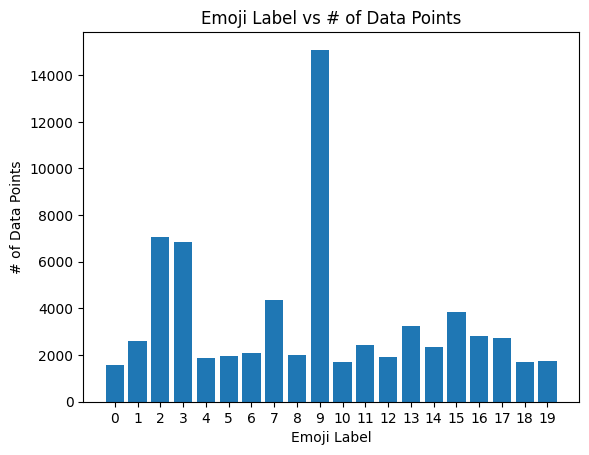

In [ ]:
plt.bar(vals,counts)
plt.xticks(vals)
plt.xlabel('Emoji Label')
plt.ylabel('# of Data Points')
plt.title('Emoji Label vs # of Data Points')
plt.show()

# SMOTE For Oversampling

- As we can see in the bar-graph below that the dataset is highly imbalanced as some of the emoji classes have a high representation in the training dataset whereas some of them do not have a high representation in the training dataset
- Inorder to handle this imbalance in dataset we use a technique known as **SMOTE** which stands for '**S**ynthetic **M**inority **O**versampling **Te**chnique'
- Basically using this technique we can create synthetic datapoints using the datapoints in the training dataset which are similar to the minority class samples
- The goal is to provide the learning algorithm with a more balanced set of examples

Before SMOTE

<img src="https://machinelearningmastery.com/wp-content/uploads/2019/10/Scatter-Plot-of-Imbalanced-Binary-Classification-Problem.png" width="500"/>

After SMOTE

<img src="https://machinelearningmastery.com/wp-content/uploads/2019/10/Scatter-Plot-of-Imbalanced-Binary-Classification-Problem-Transformed-by-SMOTE.png" width="500"/>

In [ ]:
#First we need to convert the token stream to corresponding vector representation
Xtrain = tokens_to_embedding(Xtrain)

In [ ]:
#flattening the entire training dataset into a 2d-array basically
#basically before flattening each datapoint was a 20X50 matrix and now we flatten it to a 1000sized single dimensional array
#we are flattening the datapoints because for applying SMOTE technique each datapoint should be a vector and not a matrix
Xtrain = Xtrain.reshape(Xtrain.shape[0],-1)

In [ ]:
sm = SMOTE() #applying SMOTE
Xtrain,Ytrain = sm.fit_resample(Xtrain,Ytrain)

In [ ]:
Xtrain = Xtrain.reshape(-1,max_len,emb_size) #again reshaping each datapoint to 20X50 matrix

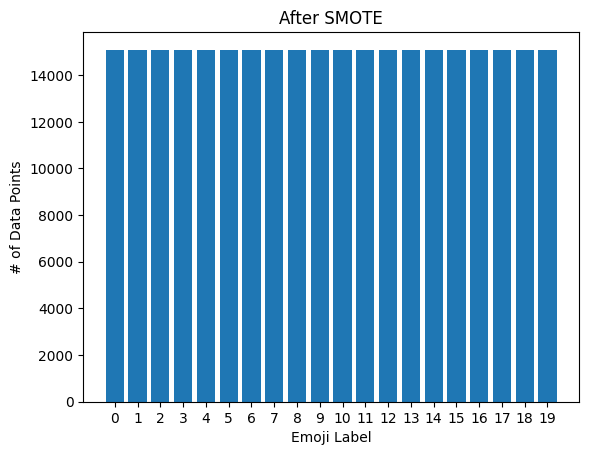

In [ ]:
vals,counts = np.unique(Ytrain,return_counts=True,axis=0)
vals = np.argmax(vals,axis=1)
plt.bar(vals,counts)
plt.xticks(vals)
plt.xlabel('Emoji Label')
plt.ylabel('# of Data Points')
plt.title("After SMOTE")
plt.show()

# Model

- For this problem we use Bidirectional LSTM layers, Dropout Layers and Fully Connected Dense Layers
- But before that we need to split the dataset into a train and test set. For this we use the train_test_split function

In [ ]:
from sklearn.model_selection import train_test_split
Xtrain,xtest,Ytrain,ytest = train_test_split(Xtrain,Ytrain,random_state=42,test_size=0.2)

RELU

<img src="https://machinelearningmastery.com/wp-content/uploads/2018/10/Line-Plot-of-Rectified-Linear-Activation-for-Negative-and-Positive-Inputs.png" width="500"/>

Softmax

<img src="https://miro.medium.com/v2/resize:fit:1400/1*de5BTgQXIV2uLckxrkN85Q.png" width="500"/>

Fully Connected Layer

<img src="https://docscontent.nvidia.com/dita/00000189-949d-d46e-abe9-bcdf9f8c0000/deeplearning/performance/dl-performance-fully-connected/graphics/fc-layer.svg" width="500"/>

Dropout

<img src="https://www.baeldung.com/wp-content/uploads/sites/4/2020/05/2-1-2048x745-1.jpg" width="1000" />

In [ ]:
model = Sequential() #Sequential basically creates a feed forward network which basically means that the model is a linear stack of different layers where data flows from one layer to another
#now we are going to add different layers to out model
model.add(Bidirectional(LSTM(units = 512, return_sequences=True), input_shape = (max_len,emb_size))) # Bidirectional means that the input is processed in both forward and backward directions
model.add(Dropout(0.3)) #a dropout layer basically prevents overfitting which means that during one iteration of gradient descent 30% of units(selected randomly) in the above LSTM layer will be ignored from training
model.add(Bidirectional(LSTM(units=256)))
model.add(Dropout(0.3))
model.add(Dense(units=128, activation='relu')) #this is just a normal Fully connected layer with a 'relu' activation function
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=20, activation='softmax')) #final layer in the model which returns a 20d vector with each entry representing the probability of the input belonging to that class
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 20, 1024)          2306048   
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 20, 1024)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 512)               2623488   
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 64)                8

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy']) # defining loss function

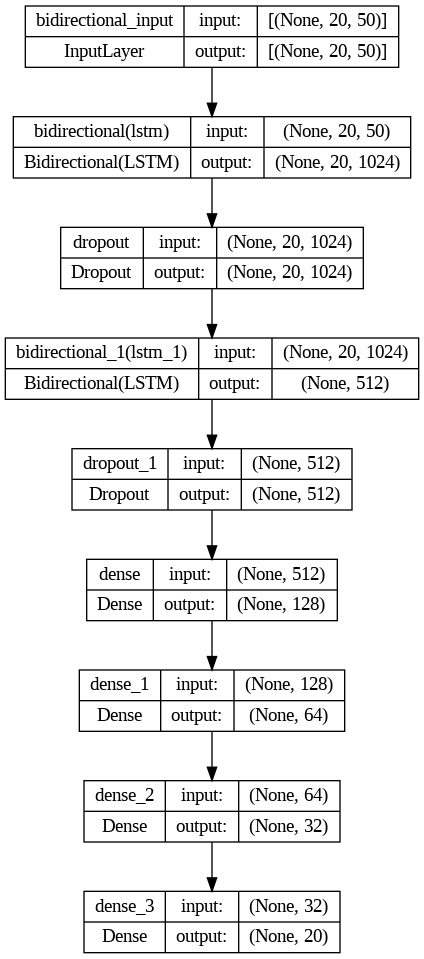

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True) # plotting a figure to represent the model architecture

In [ ]:
# the following line will train the model but for this session we are not going to train the model as it would take a lot of time and rather we will load a model trained before
# hist = model.fit(Xtrain,Ytrain,epochs=25,batch_size=64,shuffle=True,validation_split=0.2)
# model.save('/content/drive/MyDrive/tiwtter_dataset/models')

Epoch 1/25
3019/3019 [==============================] - 86s 25ms/step - loss: 2.5401 - accuracy: 0.2229 - val_loss: 2.2710 - val_accuracy: 0.3098
Epoch 2/25
3019/3019 [==============================] - 72s 24ms/step - loss: 1.9880 - accuracy: 0.3952 - val_loss: 1.6925 - val_accuracy: 0.4912
Epoch 3/25
3019/3019 [==============================] - 72s 24ms/step - loss: 1.3863 - accuracy: 0.5791 - val_loss: 1.2235 - val_accuracy: 0.6334
Epoch 4/25
3019/3019 [==============================] - 72s 24ms/step - loss: 0.9703 - accuracy: 0.7025 - val_loss: 0.9857 - val_accuracy: 0.7090
Epoch 5/25
3019/3019 [==============================] - 68s 22ms/step - loss: 0.7289 - accuracy: 0.7743 - val_loss: 0.8794 - val_accuracy: 0.7462
Epoch 6/25
3019/3019 [==============================] - 72s 24ms/step - loss: 0.5868 - accuracy: 0.8162 - val_loss: 0.8142 - val_accuracy: 0.7686
Epoch 7/25
3019/3019 [==============================] - 72s 24ms/step - loss: 0.4902 - accuracy: 0.8450 - val_loss: 0.7800 -

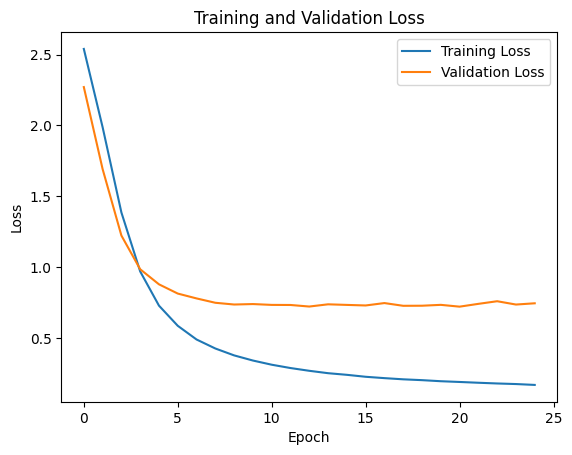

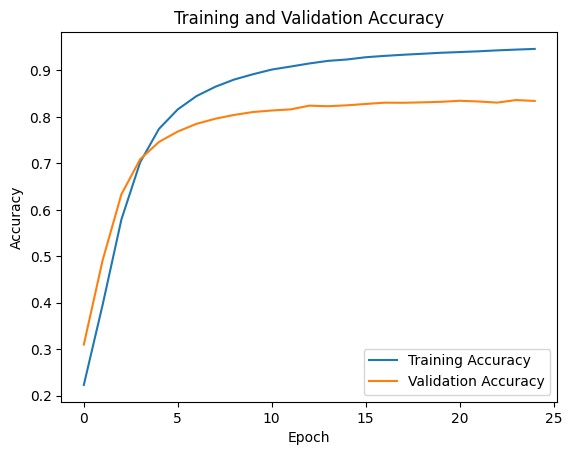

In [ ]:
# Plotting the losses during training

# plt.plot(hist.history['loss'],label='Training Loss')
# plt.plot(hist.history['val_loss'],label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# plt.plot(hist.history['accuracy'],label='Training Accuracy')
# plt.plot(hist.history['val_accuracy'],label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# Loading the model

In [ ]:
model = tf.keras.models.load_model('/content/twitter_dataset/models')

In [ ]:
#evaluating the model
xtest = xtest[:100]
ytest = ytest[:100]
model.evaluate(xtest,ytest)

4/4 [==============================] - 2s 33ms/step - loss: 0.6709 - accuracy: 0.8700


[0.670879065990448, 0.8700000047683716]

4/4 [==============================] - 4s 8ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.75      0.86         4
           2       0.80      0.67      0.73         6
           3       0.80      1.00      0.89         4
           4       1.00      1.00      1.00         3
           5       0.75      1.00      0.86         3
           6       1.00      0.71      0.83         7
           7       0.67      1.00      0.80         2
           8       1.00      1.00      1.00         3
           9       0.40      0.50      0.44         4
          10       1.00      0.86      0.92         7
          11       1.00      1.00      1.00        10
          12       1.00      1.00      1.00         4
          13       1.00      1.00      1.00         6
          14       0.83      1.00      0.91         5
          15       0.62      1.00      0.77         5
          16       1.00      0

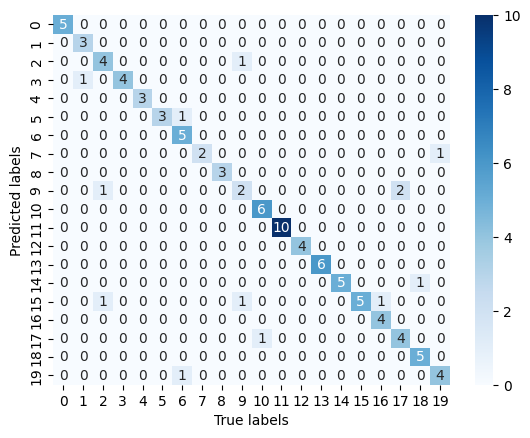

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
predicted = model.predict(xtest)
print(classification_report(np.argmax(predicted,axis=1),np.argmax(ytest,axis=1)))
cm = confusion_matrix(np.argmax(ytest,axis=1),np.argmax(predicted,axis=1))
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues")
plt.xlabel("True labels")
plt.ylabel("Predicted labels")
plt.show()

# Chatbot Interface

In [ ]:
def tokenize(text):
    """
    Function to tokenize the text
    """
    text = np.array([clean(text)])
    text = tokenizer.texts_to_sequences(text)
    text = pad_sequences(text, maxlen=max_len, padding="post")
    return text

In [ ]:
def predictEmoji(Y):
    return np.argmax(Y)

In [ ]:
def getResponse(text):
    tokens = tokenize(text)
    emb_vec = tokens_to_embedding(tokens)
    y = model.predict(emb_vec, verbose=0)
    predictedEmoji = predictEmoji(y)
    if(y[0][predictedEmoji]<0.5):
      return 'Undetected sentiment ❓❓❓'
    return emoji_mapping['emoji'][predictedEmoji]

In [ ]:
# Driver code
while True:
    text = input("> ")
    if text == "exit":
        break
    print(getResponse(text))

😊
🎄
❤
😂
Undetected sentiment ❓❓❓
